# Data Analysis

Let's better understand what we're dealing with. What does the data look like?

---

In [1]:
# Set up the env.
#!conda init
#!conda env list ## to see the availble options
#!conda activate civil_unrest ## to activate the targeted env


In [2]:
# Imports
import pandas as pd
from matplotlib import pyplot as plt
import folium
from matplotlib import colors
from geopy.distance import geodesic

#%pip install folium pandas matplotlib geopy

--- 

Let's load the data

---

In [3]:
# Load the data from the CSV file
data = pd.read_csv('data.csv')

# Display the first few rows of the dataframe
data.head()

SQLDATE  EventCode                            ActionGeo_FullName  \
0  20240823        145           Union Park, Illinois, United States   
1  20240822        145           Union Park, Illinois, United States   
2  20240820        145           Union Park, Illinois, United States   
3  20240820        145           Union Park, Illinois, United States   
4  20240627        145  Buckingham Fountain, Illinois, United States   

   ActionGeo_Lat  ActionGeo_Long   AvgTone  
0        41.8839        -87.6648 -3.046968  
1        41.8839        -87.6648  0.000000  
2        41.8839        -87.6648 -4.319654  
3        41.8839        -87.6648 -4.319654  
4        41.8756        -87.6189 -7.052186

---

## Event Date & Time

Let's take a look at when the events occured.

### Data Accuracy
taking a closer look at timeline of events will allow us to ensure it captures notable & important events. What sticks out most about my commute to school was that I passed through the loop. There's notable events that in the loop that we'd want to capture in this data set. Did they actually occur?

#### Notable Events

**2020: George Floyd Protests**

The death of George Floyd in May 2020 led to nationwide protests, with Chicago experiencing significant unrest. On May 31, the city recorded its deadliest day in at least 30 years, with 18 homicides within a 24-hour period. The violence coincided with protests that included rioting and looting, overwhelming the city's emergency response systems. 

**2024: Democratic National Convention Protests**

During the Democratic National Convention in August 2024, Chicago faced significant disruptions from pro-Palestinian protesters. These demonstrations led to confrontations with law enforcement and caused substantial disturbances in the city. 

These events highlight periods where protests in Chicago escalated into dangerous situations, impacting both public safety and city operations.


---

In [4]:
# Create a copy of the data DataFrame
data_copy = data.copy()

# Convert SQLDATE to datetime format
data_copy['SQLDATE'] = pd.to_datetime(data_copy['SQLDATE'], format='%Y%m%d')

# Aggregate the data by date to avoid duplicate labels
data_aggregated = data_copy.groupby('SQLDATE').size().reset_index(name='Number of Events')

# Set the date column as the index
data_aggregated.set_index('SQLDATE', inplace=True)

# Create a date range from the minimum to the maximum date in the DataFrame
all_dates = pd.date_range(start=data_aggregated.index.min(), end=data_aggregated.index.max())

# Reindex the DataFrame to include all dates in the range, filling missing values with 0
event_counts_df = data_aggregated.reindex(all_dates, fill_value=0).reset_index()

# Rename the columns
event_counts_df.columns = ['SQLDATE', 'Number of Events']

# Display the resulting DataFrame
event_counts_df



SQLDATE  Number of Events
0    2015-12-25                 1
1    2015-12-26                 0
2    2015-12-27                 0
3    2015-12-28                 0
4    2015-12-29                 0
...         ...               ...
3160 2024-08-19                 0
3161 2024-08-20                 2
3162 2024-08-21                 0
3163 2024-08-22                 1
3164 2024-08-23                 1

[3165 rows x 2 columns]

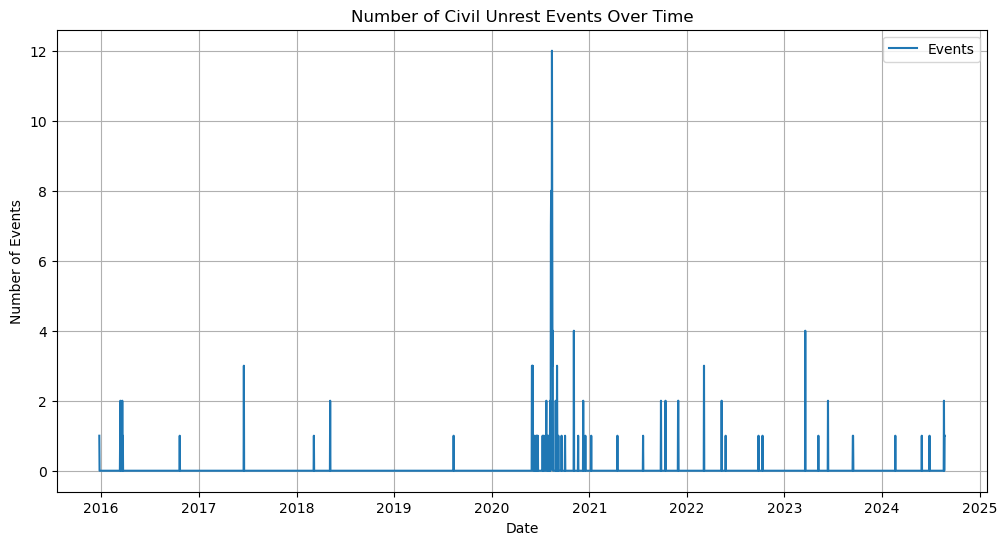

In [5]:
# Plot the number of events over time for April, May, June 2020 and August 2024 data
plt.figure(figsize=(12, 6))

# Plot April, May, June 2020 data
plt.plot(event_counts_df['SQLDATE'], event_counts_df['Number of Events'], label='Events')

plt.title('Number of Civil Unrest Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()
#

---

## Event Location

---

One other thing I want to check - is there any duplicate events at the same location? What woudl that mean?

---

In [6]:
# Check for duplicate events based on all columns
duplicate_events = data[data.duplicated()]

# Display the duplicate events
duplicate_events
# Check for duplicate events based on geographic location (latitude and longitude)
duplicate_events_geo = data[data.duplicated(subset=['ActionGeo_Lat', 'ActionGeo_Long'])]

# Display the duplicate events based on geographic location
duplicate_events_geo

SQLDATE  EventCode                                 ActionGeo_FullName  \
1    20240822        145                Union Park, Illinois, United States   
2    20240820        145                Union Park, Illinois, United States   
3    20240820        145                Union Park, Illinois, United States   
6    20240220        145  Art Institute Of Chicago, Illinois, United States   
7    20230915        145  Art Institute Of Chicago, Illinois, United States   
..        ...        ...                                                ...   
142  20160320        145  University Of Illinois At Chicago, Illinois, U...   
143  20160313        145  University Of Illinois At Chicago, Illinois, U...   
144  20160313        145  University Of Illinois At Chicago, Illinois, U...   
145  20160312        145              Chicago Loop, Illinois, United States   
146  20151225        145         Water Tower Place, Illinois, United States   

     ActionGeo_Lat  ActionGeo_Long    AvgTone  
1          41.8839        -87.6648   0.000000  
2          41.8839        -87.6648  -4.319654  
3          41.8839        -87.6648  -4.319654  
6          41.8795        -87.6223  -0.286670  
7          41.8795        -87.6223  -1.963534  
..             ...             ...        ...  
142        41.8720        -87.6492  -7.417219  
143        41.8720        -87.6492  -8.571429  
144        41.8720        -87.6492  -8.571429  
145        41.8811        -87.6298  -2.366864  
146        41.8978        -87.6237 -12.850954  

[121 rows x 6 columns]

In [7]:
# Group the data by latitude and longitude and count the number of events at each location
event_counts = data.groupby(['ActionGeo_Lat', 'ActionGeo_Long']).size().reset_index(name='counts')

# Create a new map centered around the midpoint of the expanded rectangle
m = folium.Map(location=[mid_lat, mid_lon], zoom_start=13)

# Add a rectangle to the map
folium.Rectangle(
    bounds=[
        [expanded_coords['start_lat'], expanded_coords['start_lon']],
        [expanded_coords['end_lat'], expanded_coords['end_lon']]
    ],
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.2
).add_to(m)

# Add starting point marker
folium.Marker(
    location=[start_lat, start_lon],
    popup='Starting Point',
    icon=folium.Icon(color='green')
).add_to(m)

# Add ending point marker
folium.Marker(
    location=[end_lat, end_lon],
    popup='Ending Point',
    icon=folium.Icon(color='red')
).add_to(m)

# Define a colormap
colormap = plt.cm.get_cmap('Reds')

# Normalize the AvgTone values to the range [0, 1]
norm = colors.Normalize(vmin=data['AvgTone'].min(), vmax=data['AvgTone'].max())
# Calculate the average tone for each location
avg_tone_by_location = data.groupby(['ActionGeo_Lat', 'ActionGeo_Long'])['AvgTone'].mean().reset_index()

# Normalize the AvgTone values to the range [0, 1]
norm = colors.Normalize(vmin=avg_tone_by_location['AvgTone'].min(), vmax=avg_tone_by_location['AvgTone'].max())

# Add markers for each event location in the event_counts DataFrame
for index, row in event_counts.iterrows():
    # Get the color based on the normalized AvgTone value
    avg_tone = data[(data['ActionGeo_Lat'] == row['ActionGeo_Lat']) & (data['ActionGeo_Long'] == row['ActionGeo_Long'])]['AvgTone'].mean()
    color = colors.rgb2hex(colormap(norm(avg_tone)))
    folium.Circle(
        location=[row['ActionGeo_Lat'], row['ActionGeo_Long']],
        radius=row['counts'] * 10,  # Adjust the multiplier as needed to scale the radius
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Location: ({row['ActionGeo_Lat']}, {row['ActionGeo_Long']}), Events: {row['counts']}, AvgTone: {avg_tone:.2f}"
    ).add_to(m)

# Display the updated map
m

NameError: name 'mid_lat' is not defined

In [6]:
# Convert SQLDATE to datetime format using .loc
data.loc[:, 'SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')

reindex_data = data.copy()
reindex_data = reindex_data.groupby('SQLDATE').size().reindex(pd.date_range(start=reindex_data['SQLDATE'].min(), 
                                                                          end=reindex_data['SQLDATE'].max()), 
                                                                          fill_value=0).reset_index()
reindex_data.columns = ['SQLDATE', 'Number of Events']
reindex_data

/var/folders/bh/bs5kljm140s_4k8bp_hzf8n00000gn/T/ipykernel_10663/421373191.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2024-12-11 00:00:00', '2024-12-11 00:00:00', '2024-12-06 00:00:00',
 '2024-12-02 00:00:00', '2024-12-02 00:00:00', '2024-12-02 00:00:00',
 '2024-11-18 00:00:00', '2024-11-06 00:00:00', '2024-10-30 00:00:00',
 '2024-10-29 00:00:00',
 ...
 '2015-03-26 00:00:00', '2015-03-16 00:00:00', '2015-03-04 00:00:00',
 '2015-02-22 00:00:00', '2015-01-30 00:00:00', '2015-01-19 00:00:00',
 '2015-01-19 00:00:00', '2015-01-19 00:00:00', '2015-01-19 00:00:00',
 '2015-01-08 00:00:00']
Length: 3349, dtype: datetime64[ns]' has dtype incompatible with Int64, please explicitly cast to a compatible dtype first.
  data.loc[:, 'SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')


SQLDATE  Number of Events
0    2015-01-08                 1
1    2015-01-09                 0
2    2015-01-10                 0
3    2015-01-11                 0
4    2015-01-12                 0
...         ...               ...
3621 2024-12-07                 0
3622 2024-12-08                 0
3623 2024-12-09                 0
3624 2024-12-10                 0
3625 2024-12-11                 2

[3626 rows x 2 columns]

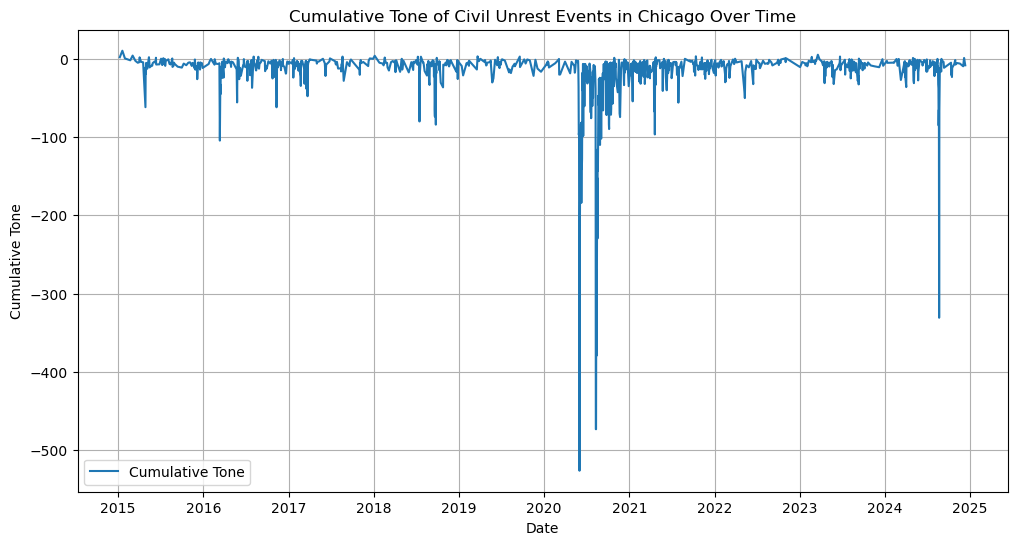

In [21]:
def cuml_tone(dates, df):
    cuml_tone = {}

    row = 0
    for date in df['SQLDATE']:
        if date in cuml_tone:
            cuml_tone[date] = cuml_tone[date] + df.iloc[row]['AvgTone']
        else:
            cuml_tone[date] = df.iloc[row]['AvgTone']
        row += 1

    daily_cuml_tone = []
    for date in dates:
        daily_cuml_tone.append(cuml_tone[date])

    return daily_cuml_tone

# Let's plot all of the points
plt.figure(figsize=(12, 6))
plt.plot(data['SQLDATE'], cuml_tone(data['SQLDATE'], data), label='Cumulative Tone')
plt.title('Cumulative Tone of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Tone')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Create a base map centered around Chicago
m = folium.Map(location=[41.8500, -87.6501], zoom_start=12)

# Normalize AvgTone to a range between 0 and 1 for color mapping
norm = plt.Normalize(vmin=data['AvgTone'].min(), vmax=data['AvgTone'].max())

# Add points to the map with gradient color
for _, row in data.iterrows():
    color = plt.cm.RdYlBu_r(norm(row['AvgTone']))  # Use a reversed colormap (RdYlBu_r)
    folium.CircleMarker(
        location=[row['ActionGeo_Lat'], row['ActionGeo_Long']],
        radius=10,  # Increase the radius to make dots larger
        popup=f"Date: {row['SQLDATE']}\nAvgTone: {row['AvgTone']}",
        color=colors.rgb2hex(color[:3]),  # Convert RGBA to hex
        fill=True,
        fill_color=colors.rgb2hex(color[:3])
    ).add_to(m)

# Display the map
m

In [10]:
# More packages to install!
#%pip install geopy

In [11]:
# Define the center of the Chicago Loop
chicago_loop_center = (41.8811, -87.6297)

# Function to calculate distance from the center of the Chicago Loop
def is_within_one_mile(row):
    event_location = (row['ActionGeo_Lat'], row['ActionGeo_Long'])
    distance = geodesic(chicago_loop_center, event_location).miles
    return distance <= 1

# Apply the function to filter the data
filtered_data = data[data.apply(is_within_one_mile, axis=1)]

filtered_data

SQLDATE EventCode                                 ActionGeo_FullName  \
255  2024-05-29       145  Art Institute Of Chicago, Illinois, United States   
341  2024-02-20       145  Art Institute Of Chicago, Illinois, United States   
373  2023-09-15       145  Art Institute Of Chicago, Illinois, United States   
374  2023-09-14       145  Art Institute Of Chicago, Illinois, United States   
456  2023-05-08       145             Chicago River, Illinois, United States   
...         ...       ...                                                ...   
2329 2020-06-01       145              Chicago Loop, Illinois, United States   
2358 2020-05-31       145             Chicago River, Illinois, United States   
2392 2020-05-31       145             Chicago River, Illinois, United States   
2792 2018-03-07       145  School Of The Art Institute Of Chicago, Illino...   
3207 2016-03-12       145              Chicago Loop, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  
255         41.8795        -87.6223 -1.477105  
341         41.8795        -87.6223 -0.286670  
373         41.8795        -87.6223 -1.963534  
374         41.8795        -87.6223 -1.963534  
456         41.8867        -87.6373 -4.545455  
...             ...             ...       ...  
2329        41.8811        -87.6298 -6.817213  
2358        41.8867        -87.6373 -6.977679  
2392        41.8867        -87.6373 -3.030303  
2792        41.8789        -87.6217 -2.269861  
3207        41.8811        -87.6298 -2.366864  

[65 rows x 6 columns]

In [12]:
filtered_data


SQLDATE EventCode                                 ActionGeo_FullName  \
255  2024-05-29       145  Art Institute Of Chicago, Illinois, United States   
341  2024-02-20       145  Art Institute Of Chicago, Illinois, United States   
373  2023-09-15       145  Art Institute Of Chicago, Illinois, United States   
374  2023-09-14       145  Art Institute Of Chicago, Illinois, United States   
456  2023-05-08       145             Chicago River, Illinois, United States   
...         ...       ...                                                ...   
2329 2020-06-01       145              Chicago Loop, Illinois, United States   
2358 2020-05-31       145             Chicago River, Illinois, United States   
2392 2020-05-31       145             Chicago River, Illinois, United States   
2792 2018-03-07       145  School Of The Art Institute Of Chicago, Illino...   
3207 2016-03-12       145              Chicago Loop, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  
255         41.8795        -87.6223 -1.477105  
341         41.8795        -87.6223 -0.286670  
373         41.8795        -87.6223 -1.963534  
374         41.8795        -87.6223 -1.963534  
456         41.8867        -87.6373 -4.545455  
...             ...             ...       ...  
2329        41.8811        -87.6298 -6.817213  
2358        41.8867        -87.6373 -6.977679  
2392        41.8867        -87.6373 -3.030303  
2792        41.8789        -87.6217 -2.269861  
3207        41.8811        -87.6298 -2.366864  

[65 rows x 6 columns]

In [13]:
data

SQLDATE EventCode                              ActionGeo_FullName  \
0    2024-12-11       145                Chicago, Illinois, United States   
1    2024-12-11       145                Chicago, Illinois, United States   
2    2024-12-06       145                Chicago, Illinois, United States   
3    2024-12-02       145  University Of Chicago, Illinois, United States   
4    2024-12-02       145                Chicago, Illinois, United States   
...         ...       ...                                             ...   
3344 2015-01-19       145                Chicago, Illinois, United States   
3345 2015-01-19       145                Chicago, Illinois, United States   
3346 2015-01-19       145                Chicago, Illinois, United States   
3347 2015-01-19       145                Chicago, Illinois, United States   
3348 2015-01-08       145                Chicago, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  
0           41.8500        -87.6501 -4.147465  
1           41.8500        -87.6501 -4.147465  
2           41.8500        -87.6501  1.066667  
3           41.7898        -87.5998 -0.843289  
4           41.8500        -87.6501 -7.840083  
...             ...             ...       ...  
3344        41.8500        -87.6501  2.494577  
3345        41.8500        -87.6501  2.494577  
3346        41.8500        -87.6501  2.494577  
3347        41.8500        -87.6501  2.857143  
3348        41.8500        -87.6501  2.007772  

[3349 rows x 6 columns]

In [14]:
cuml_tone(filtered_data['SQLDATE'])

[-8.29493087557604,
 -8.29493087557604,
 1.06666666666667,
 -9.52666072657402,
 -9.52666072657402,
 -9.52666072657402,
 -6.06767794632438,
 -5.40265035677879,
 -7.37951807228916,
 -1.57273918741808,
 -1.57273918741808,
 -6.5625,
 -11.52398871119472,
 -11.52398871119472,
 -23.26860584925103,
 -23.26860584925103,
 -23.26860584925103,
 -10.8552631578947,
 -20.90177359726707,
 -20.90177359726707,
 -20.90177359726707,
 -19.950424462555958,
 -19.950424462555958,
 -19.950424462555958,
 -19.950424462555958,
 -4.95049504950496,
 -11.46131805157594,
 -11.46131805157594,
 -4.07938257993385,
 -3.0712612914018,
 -2.50250250250251,
 -0.10319917440661,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -13.62962962962964,
 -13.62962962962964,
 -13.62962962962964,
 -13.62962962962964,
 -4.739336492891,
 -15.258776914354861,
 -15.258776914354861,
 -15.258776914354861,
 -11.402518676230638,
 -11.402518676230638,
 -11.402518676230638,
 -11.9551574302

In [15]:
filtered_data['SQLDATE']

255    2024-05-29
341    2024-02-20
373    2023-09-15
374    2023-09-14
456    2023-05-08
          ...    
2329   2020-06-01
2358   2020-05-31
2392   2020-05-31
2792   2018-03-07
3207   2016-03-12
Name: SQLDATE, Length: 65, dtype: datetime64[ns]

In [16]:
cuml_tone(filtered_data['SQLDATE'])

[-8.29493087557604,
 -8.29493087557604,
 1.06666666666667,
 -9.52666072657402,
 -9.52666072657402,
 -9.52666072657402,
 -6.06767794632438,
 -5.40265035677879,
 -7.37951807228916,
 -1.57273918741808,
 -1.57273918741808,
 -6.5625,
 -11.52398871119472,
 -11.52398871119472,
 -23.26860584925103,
 -23.26860584925103,
 -23.26860584925103,
 -10.8552631578947,
 -20.90177359726707,
 -20.90177359726707,
 -20.90177359726707,
 -19.950424462555958,
 -19.950424462555958,
 -19.950424462555958,
 -19.950424462555958,
 -4.95049504950496,
 -11.46131805157594,
 -11.46131805157594,
 -4.07938257993385,
 -3.0712612914018,
 -2.50250250250251,
 -0.10319917440661,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -13.62962962962964,
 -13.62962962962964,
 -13.62962962962964,
 -13.62962962962964,
 -4.739336492891,
 -15.258776914354861,
 -15.258776914354861,
 -15.258776914354861,
 -11.402518676230638,
 -11.402518676230638,
 -11.402518676230638,
 -11.9551574302

In [17]:
data['SQLDATE']


0      2024-12-11
1      2024-12-11
2      2024-12-06
3      2024-12-02
4      2024-12-02
          ...    
3344   2015-01-19
3345   2015-01-19
3346   2015-01-19
3347   2015-01-19
3348   2015-01-08
Name: SQLDATE, Length: 3349, dtype: datetime64[ns]

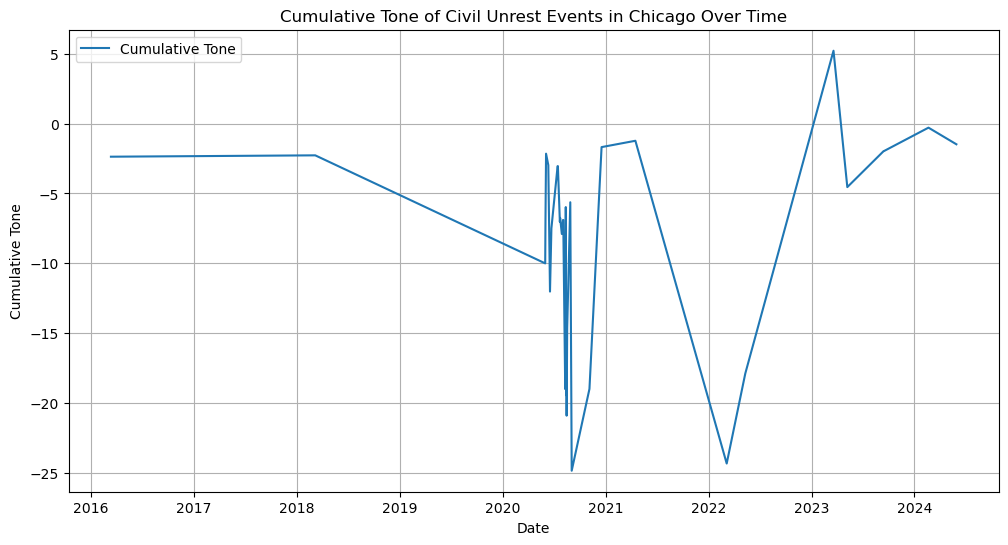

In [22]:
# Let's plot all of the points
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['SQLDATE'], cuml_tone(filtered_data['SQLDATE'],filtered_data), label='Cumulative Tone')
plt.title('Cumulative Tone of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Tone')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Create a base map centered around Chicago
m = folium.Map(location=list(chicago_loop_center), zoom_start=15)

# Normalize AvgTone to a range between 0 and 1 for color mapping
norm = plt.Normalize(vmin=filtered_data['AvgTone'].min(), vmax=filtered_data['AvgTone'].max())

# Add points to the map with gradient color
for _, row in filtered_data.iterrows():
    color = plt.cm.RdYlBu_r(norm(row['AvgTone']))  # Use a reversed colormap (RdYlBu_r)
    folium.CircleMarker(
        location=[row['ActionGeo_Lat'], row['ActionGeo_Long']],
        radius=10,  # Increase the radius to make dots larger
        popup=f"Date: {row['SQLDATE']}\nAvgTone: {row['AvgTone']}",
        color=colors.rgb2hex(color[:3]),  # Convert RGBA to hex
        fill=True,
        fill_color=colors.rgb2hex(color[:3])
    ).add_to(m)

# Display the map
m

In [58]:
# Convert SQLDATE to datetime format using .loc
filtered_data.loc[:, 'SQLDATE'] = pd.to_datetime(filtered_data['SQLDATE'], format='%Y%m%d')

train_data = filtered_data[filtered_data['SQLDATE'] < '2021-01-01']
train_data = train_data.groupby('SQLDATE').size().reindex(pd.date_range(start=train_data['SQLDATE'].min(), end=train_data['SQLDATE'].max()), fill_value=0).reset_index()
train_data.columns = ['SQLDATE', 'Number of Events']

test_data = filtered_data[filtered_data['SQLDATE'] >= '2021-01-01']
test_data = test_data.groupby('SQLDATE').size().reindex(pd.date_range(start=test_data['SQLDATE'].min(), end=test_data['SQLDATE'].max()), fill_value=0).reset_index()
test_data.columns = ['SQLDATE', 'Number of Events']

In [59]:
train_data.columns

Index(['SQLDATE', 'Number of Events'], dtype='object')

In [60]:
test_data.columns

Index(['SQLDATE', 'Number of Events'], dtype='object')

In [61]:
# Save the results to CSV files
train_data.to_csv("chicago_violent_protests_train.csv", index=True)
print("Training data saved to 'chicago_violent_protests_train.csv'")

test_data.to_csv("chicago_violent_protests_test.csv", index=True)
print("Testing data saved to 'chicago_violent_protests_test.csv'")

Training data saved to 'chicago_violent_protests_train.csv'
Testing data saved to 'chicago_violent_protests_test.csv'


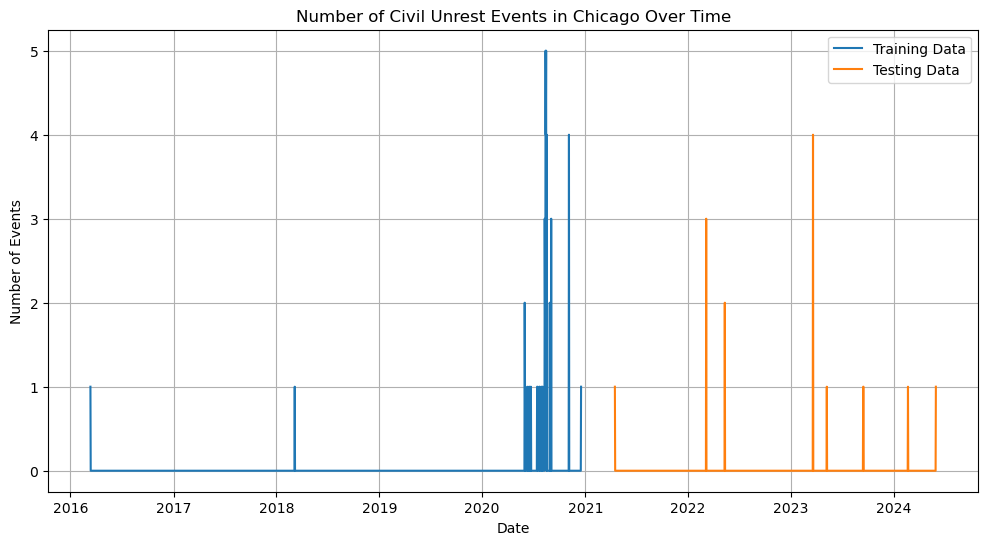

In [62]:
# Plot the number of events over time for training and testing data
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_data['SQLDATE'], train_data['Number of Events'], label='Training Data')

# Plot testing data
plt.plot(test_data['SQLDATE'], test_data['Number of Events'], label='Testing Data')

plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

I'm curious. If we express this as a product of tones, what would that look like?

---

It looks like half of these events were captured. With the George Floyd and DNC events being more significant, I feel confident this data is still good; however, it'll be important to ensure the data we pulled actually is associated with the personal risk of an individual in Chicago. Seeing as the major protests of George Floyd and the DNC protests were far more signficant in nature than other protest, then I feel this is acceptable. 

We should return to see if we can naunce this further.

---

---
## Data Collection Is Effective

At this point, it's clear I've been able to collect the right data from Chicago. We're going to assume the data is clean & correct for now. I may return to review later.

## Training and Testing

At this point it would be nice to create the training and testing data. We'll train on data from 2015 to 2021 (because I want to capture the peak from COVID). In the testing data, it would be ideal to accurately predict the protest activity in mid-2024. 

Let's pull the full data set, split it, and then see how it looks to continue and understand how we would build this model.

---